**Build and experiment with advanced LSTM model variant for RUL prediction.**

**1 . Import necessary libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from datetime import datetime
import json

**2 . Data Loading**

In [ ]:
TRAIN_FILE = '/content/train_FD001.txt'  # Adjust if file name differs

# Column names for CMAPSS FD001
CMAPSS_COLS = ['engine_id', 'cycle', 'os1','os2','os3'] + [f'sensor_{i}' for i in range(1,22)]

# Verify file exists
import os
assert os.path.exists(TRAIN_FILE), f"{TRAIN_FILE} not found!"

# Read the file using a raw string for the regex separator
train_df = pd.read_csv(TRAIN_FILE, sep=r"\s+", header=None, engine='python', names=CMAPSS_COLS)

# Compute Remaining Useful Life (RUL)
train_df['RUL'] = train_df.groupby('engine_id')['cycle'].transform(max) - train_df['cycle']

print('Train shape:', train_df.shape)
print(train_df.head())

Train shape: (20631, 27)
   engine_id  cycle     os1     os2    os3  sensor_1  sensor_2  sensor_3  \
0          1      1 -0.0007 -0.0004  100.0    518.67    641.82   1589.70   
1          1      2  0.0019 -0.0003  100.0    518.67    642.15   1591.82   
2          1      3 -0.0043  0.0003  100.0    518.67    642.35   1587.99   
3          1      4  0.0007  0.0000  100.0    518.67    642.35   1582.79   
4          1      5 -0.0019 -0.0002  100.0    518.67    642.37   1582.85   

   sensor_4  sensor_5  ...  sensor_13  sensor_14  sensor_15  sensor_16  \
0   1400.60     14.62  ...    2388.02    8138.62     8.4195       0.03   
1   1403.14     14.62  ...    2388.07    8131.49     8.4318       0.03   
2   1404.20     14.62  ...    2388.03    8133.23     8.4178       0.03   
3   1401.87     14.62  ...    2388.08    8133.83     8.3682       0.03   
4   1406.22     14.62  ...    2388.04    8133.80     8.4294       0.03   

   sensor_17  sensor_18  sensor_19  sensor_20  sensor_21  RUL  
0        

/tmp/ipython-input-1487285895.py:14: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  train_df['RUL'] = train_df.groupby('engine_id')['cycle'].transform(max) - train_df['cycle']


**3 . Train/Validation Split**

In [ ]:
engine_ids = train_df['engine_id'].unique()
train_ids, val_ids = train_test_split(engine_ids, test_size=0.2, random_state=42)

train_data = train_df[train_df['engine_id'].isin(train_ids)].reset_index(drop=True)
val_data = train_df[train_df['engine_id'].isin(val_ids)].reset_index(drop=True)

print(f"Engines - total: {len(engine_ids)}, train: {len(train_ids)}, val: {len(val_ids)}")

Engines - total: 100, train: 80, val: 20


**4 . Define Model Architectures**

In [ ]:
SEQ_LEN = 30
FEATURE_COLS = ['os1','os2','os3'] + [f'sensor_{i}' for i in range(1,22)]
N_FEATURES = len(FEATURE_COLS)

# Attention Layer
class AttentionLayer(layers.Layer):
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.V = self.add_weight(shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)
        super().build(input_shape)
    def call(self, inputs):
        score = K.tanh(K.dot(inputs, self.W))
        score = K.dot(score, self.V)
        attention_weights = K.softmax(score, axis=1)
        context = attention_weights * inputs
        context = K.sum(context, axis=1)
        return context

# Model definitions
def build_baseline_lstm(seq_len=SEQ_LEN, n_features=N_FEATURES):
    inp = layers.Input(shape=(seq_len, n_features))
    x = layers.LSTM(64)(inp)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    return models.Model(inp, out, name='baseline_lstm')

def build_stacked_lstm(seq_len=SEQ_LEN, n_features=N_FEATURES):
    inp = layers.Input(shape=(seq_len, n_features))
    x = layers.LSTM(128, return_sequences=True)(inp)
    x = layers.LSTM(64)(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    return models.Model(inp, out, name='stacked_lstm')

def build_bidirectional_lstm(seq_len=SEQ_LEN, n_features=N_FEATURES):
    inp = layers.Input(shape=(seq_len, n_features))
    x = layers.Bidirectional(layers.LSTM(64))(inp)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    return models.Model(inp, out, name='bidir_lstm')

def build_lstm_with_attention(seq_len=SEQ_LEN, n_features=N_FEATURES):
    inp = layers.Input(shape=(seq_len, n_features))
    x = layers.LSTM(64, return_sequences=True)(inp)
    x = AttentionLayer()(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    return models.Model(inp, out, name='lstm_attention')

def build_cnn_lstm(seq_len=SEQ_LEN, n_features=N_FEATURES):
    inp = layers.Input(shape=(seq_len, n_features))
    x = layers.Permute((2,1))(inp)
    x = layers.Conv1D(64, 3, padding='same')(x)
    x = layers.Permute((2,1))(x)
    x = layers.LSTM(64)(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    return models.Model(inp, out, name='cnn_lstm')

**5 . Instantiate and compile models**

In [ ]:
models_to_run = {
    'baseline_lstm': build_baseline_lstm(),
    'stacked_lstm': build_stacked_lstm(),
    'bidir_lstm': build_bidirectional_lstm(),
    'lstm_attention': build_lstm_with_attention(),
    'cnn_lstm': build_cnn_lstm()
}

for name, m in models_to_run.items():
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    print(f"Compiled {name}, params: {m.count_params()}")

Compiled baseline_lstm, params: 24897
Compiled stacked_lstm, params: 129857
Compiled bidir_lstm, params: 49729
Compiled lstm_attention, params: 29057
Compiled cnn_lstm, params: 30721


**6 . Prepare datasets for training**

In [ ]:
scaler = MinMaxScaler()
train_scaled = train_data.copy()
val_scaled = val_data.copy()
train_scaled[FEATURE_COLS] = scaler.fit_transform(train_scaled[FEATURE_COLS])
val_scaled[FEATURE_COLS] = scaler.transform(val_scaled[FEATURE_COLS])

def generate_sequences(df, seq_len=SEQ_LEN, feature_cols=FEATURE_COLS, label_col='RUL'):
    X_list, y_list = [], []
    for engine_id, group in df.groupby('engine_id'):
        group = group.sort_values('cycle')
        feats = group[feature_cols].values
        labels = group[label_col].values
        if len(feats) < seq_len:
            continue
        for i in range(len(feats) - seq_len + 1):
            X_list.append(feats[i:i+seq_len])
            y_list.append(labels[i+seq_len-1])
    return np.array(X_list), np.array(y_list)

X_train, y_train = generate_sequences(train_scaled)
X_val, y_val = generate_sequences(val_scaled)

print('X_train shape:', X_train.shape, 'y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape, 'y_val shape:', y_val.shape)


X_train shape: (14241, 30, 24) y_train shape: (14241,)
X_val shape: (3490, 30, 24) y_val shape: (3490,)


**7 . Setup callbacks**

In [ ]:
OUT_DIR = 'outputs'
os.makedirs(OUT_DIR, exist_ok=True)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
]


**8 . Train and compare models**

In [ ]:
HISTORIES = {}
TRAIN_EPOCHS = 80
BATCH_SIZE = 64

for name, model in models_to_run.items():
    print(f'\nTraining {name}...')
    ckpt_path = os.path.join(OUT_DIR, f'{name}_best.h5')
    mcp = ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=TRAIN_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks+[mcp], verbose=2)
    HISTORIES[name] = history


Training baseline_lstm...
Epoch 1/80

Epoch 1: val_loss improved from inf to 3435.69043, saving model to outputs/baseline_lstm_best.h5


223/223 - 4s - 20ms/step - loss: 7438.6460 - root_mean_squared_error: 86.2476 - val_loss: 3435.6904 - val_root_mean_squared_error: 58.6148 - learning_rate: 1.0000e-03
Epoch 2/80

Epoch 2: val_loss improved from 3435.69043 to 3395.17920, saving model to outputs/baseline_lstm_best.h5


223/223 - 3s - 12ms/step - loss: 3952.4348 - root_mean_squared_error: 62.8684 - val_loss: 3395.1792 - val_root_mean_squared_error: 58.2682 - learning_rate: 1.0000e-03
Epoch 3/80

Epoch 3: val_loss improved from 3395.17920 to 3307.91064, saving model to outputs/baseline_lstm_best.h5


223/223 - 5s - 22ms/step - loss: 3930.7290 - root_mean_squared_error: 62.6955 - val_loss: 3307.9106 - val_root_mean_squared_error: 57.5144 - learning_rate: 1.0000e-03
Epoch 4/80

Epoch 4: val_loss improved from 3307.91064 to 1459.72595, saving model to outputs/baseline_lstm_best.h5


223/223 - 2s - 11ms/step - loss: 2955.4958 - root_mean_squared_error: 54.3645 - val_loss: 1459.7260 - val_root_mean_squared_error: 38.2064 - learning_rate: 1.0000e-03
Epoch 5/80

Epoch 5: val_loss improved from 1459.72595 to 881.42053, saving model to outputs/baseline_lstm_best.h5


223/223 - 3s - 14ms/step - loss: 1673.9541 - root_mean_squared_error: 40.9140 - val_loss: 881.4205 - val_root_mean_squared_error: 29.6887 - learning_rate: 1.0000e-03
Epoch 6/80

Epoch 6: val_loss improved from 881.42053 to 647.68646, saving model to outputs/baseline_lstm_best.h5


223/223 - 3s - 11ms/step - loss: 1347.5223 - root_mean_squared_error: 36.7086 - val_loss: 647.6865 - val_root_mean_squared_error: 25.4497 - learning_rate: 1.0000e-03
Epoch 7/80

Epoch 7: val_loss did not improve from 647.68646
223/223 - 2s - 11ms/step - loss: 1200.8986 - root_mean_squared_error: 34.6540 - val_loss: 817.4109 - val_root_mean_squared_error: 28.5904 - learning_rate: 1.0000e-03
Epoch 8/80

Epoch 8: val_loss did not improve from 647.68646
223/223 - 3s - 13ms/step - loss: 1133.5974 - root_mean_squared_error: 33.6689 - val_loss: 674.1985 - val_root_mean_squared_error: 25.9653 - learning_rate: 1.0000e-03
Epoch 9/80

Epoch 9: val_loss improved from 647.68646 to 629.27148, saving model to outputs/baseline_lstm_best.h5


223/223 - 3s - 14ms/step - loss: 1140.9696 - root_mean_squared_error: 33.7782 - val_loss: 629.2715 - val_root_mean_squared_error: 25.0853 - learning_rate: 1.0000e-03
Epoch 10/80

Epoch 10: val_loss improved from 629.27148 to 571.62030, saving model to outputs/baseline_lstm_best.h5


223/223 - 2s - 11ms/step - loss: 1110.4257 - root_mean_squared_error: 33.3231 - val_loss: 571.6203 - val_root_mean_squared_error: 23.9086 - learning_rate: 1.0000e-03
Epoch 11/80

Epoch 11: val_loss did not improve from 571.62030
223/223 - 2s - 11ms/step - loss: 1103.8110 - root_mean_squared_error: 33.2237 - val_loss: 571.9211 - val_root_mean_squared_error: 23.9149 - learning_rate: 1.0000e-03
Epoch 12/80

Epoch 12: val_loss did not improve from 571.62030
223/223 - 2s - 11ms/step - loss: 1057.1293 - root_mean_squared_error: 32.5135 - val_loss: 707.9774 - val_root_mean_squared_error: 26.6078 - learning_rate: 1.0000e-03
Epoch 13/80

Epoch 13: val_loss did not improve from 571.62030
223/223 - 3s - 13ms/step - loss: 1019.1302 - root_mean_squared_error: 31.9238 - val_loss: 805.3382 - val_root_mean_squared_error: 28.3785 - learning_rate: 1.0000e-03
Epoch 14/80

Epoch 14: val_loss did not improve from 571.62030
223/223 - 3s - 12ms/step - loss: 1080.3809 - root_mean_squared_error: 32.8691 - val_

223/223 - 3s - 11ms/step - loss: 957.1851 - root_mean_squared_error: 30.9384 - val_loss: 533.5760 - val_root_mean_squared_error: 23.0993 - learning_rate: 5.0000e-04
Epoch 20/80

Epoch 20: val_loss did not improve from 533.57599
223/223 - 3s - 12ms/step - loss: 953.8906 - root_mean_squared_error: 30.8851 - val_loss: 713.5590 - val_root_mean_squared_error: 26.7125 - learning_rate: 5.0000e-04
Epoch 21/80

Epoch 21: val_loss did not improve from 533.57599
223/223 - 3s - 11ms/step - loss: 949.4387 - root_mean_squared_error: 30.8130 - val_loss: 554.2379 - val_root_mean_squared_error: 23.5423 - learning_rate: 5.0000e-04
Epoch 22/80

Epoch 22: val_loss did not improve from 533.57599
223/223 - 3s - 14ms/step - loss: 934.3893 - root_mean_squared_error: 30.5678 - val_loss: 589.9553 - val_root_mean_squared_error: 24.2890 - learning_rate: 5.0000e-04
Epoch 23/80

Epoch 23: val_loss did not improve from 533.57599
223/223 - 2s - 11ms/step - loss: 917.4504 - root_mean_squared_error: 30.2894 - val_loss:

223/223 - 14s - 62ms/step - loss: 7053.1592 - root_mean_squared_error: 83.9831 - val_loss: 3419.6421 - val_root_mean_squared_error: 58.4777 - learning_rate: 1.0000e-03
Epoch 2/80

Epoch 2: val_loss improved from 3419.64209 to 3394.70264, saving model to outputs/stacked_lstm_best.h5


223/223 - 11s - 51ms/step - loss: 3949.1436 - root_mean_squared_error: 62.8422 - val_loss: 3394.7026 - val_root_mean_squared_error: 58.2641 - learning_rate: 1.0000e-03
Epoch 3/80

Epoch 3: val_loss did not improve from 3394.70264
223/223 - 12s - 53ms/step - loss: 3941.8611 - root_mean_squared_error: 62.7842 - val_loss: 3406.4714 - val_root_mean_squared_error: 58.3650 - learning_rate: 1.0000e-03
Epoch 4/80

Epoch 4: val_loss did not improve from 3394.70264
223/223 - 11s - 51ms/step - loss: 3941.6052 - root_mean_squared_error: 62.7822 - val_loss: 3406.8018 - val_root_mean_squared_error: 58.3678 - learning_rate: 1.0000e-03
Epoch 5/80

Epoch 5: val_loss did not improve from 3394.70264
223/223 - 11s - 50ms/step - loss: 3942.9607 - root_mean_squared_error: 62.7930 - val_loss: 3415.0754 - val_root_mean_squared_error: 58.4386 - learning_rate: 1.0000e-03
Epoch 6/80

Epoch 6: val_loss did not improve from 3394.70264
223/223 - 21s - 92ms/step - loss: 3942.2983 - root_mean_squared_error: 62.7877 -

223/223 - 12s - 53ms/step - loss: 3346.1069 - root_mean_squared_error: 57.8455 - val_loss: 784.0766 - val_root_mean_squared_error: 28.0014 - learning_rate: 1.0000e-03
Epoch 8/80

Epoch 8: val_loss improved from 784.07660 to 714.37653, saving model to outputs/stacked_lstm_best.h5


223/223 - 11s - 51ms/step - loss: 1362.3955 - root_mean_squared_error: 36.9106 - val_loss: 714.3765 - val_root_mean_squared_error: 26.7278 - learning_rate: 1.0000e-03
Epoch 9/80

Epoch 9: val_loss did not improve from 714.37653
223/223 - 21s - 93ms/step - loss: 1156.4980 - root_mean_squared_error: 34.0073 - val_loss: 847.1819 - val_root_mean_squared_error: 29.1064 - learning_rate: 1.0000e-03
Epoch 10/80

Epoch 10: val_loss improved from 714.37653 to 570.35718, saving model to outputs/stacked_lstm_best.h5


223/223 - 11s - 50ms/step - loss: 1086.8077 - root_mean_squared_error: 32.9668 - val_loss: 570.3572 - val_root_mean_squared_error: 23.8822 - learning_rate: 1.0000e-03
Epoch 11/80

Epoch 11: val_loss did not improve from 570.35718
223/223 - 11s - 51ms/step - loss: 1054.8905 - root_mean_squared_error: 32.4791 - val_loss: 614.3846 - val_root_mean_squared_error: 24.7868 - learning_rate: 1.0000e-03
Epoch 12/80

Epoch 12: val_loss did not improve from 570.35718
223/223 - 12s - 52ms/step - loss: 1061.8442 - root_mean_squared_error: 32.5860 - val_loss: 644.3967 - val_root_mean_squared_error: 25.3850 - learning_rate: 1.0000e-03
Epoch 13/80

Epoch 13: val_loss did not improve from 570.35718
223/223 - 11s - 51ms/step - loss: 1054.0217 - root_mean_squared_error: 32.4657 - val_loss: 845.1313 - val_root_mean_squared_error: 29.0711 - learning_rate: 1.0000e-03
Epoch 14/80

Epoch 14: val_loss did not improve from 570.35718
223/223 - 11s - 51ms/step - loss: 1023.4402 - root_mean_squared_error: 31.9913 -

223/223 - 20s - 91ms/step - loss: 941.4769 - root_mean_squared_error: 30.6835 - val_loss: 544.5938 - val_root_mean_squared_error: 23.3365 - learning_rate: 2.5000e-04
Epoch 22/80

Epoch 22: val_loss did not improve from 544.59381
223/223 - 11s - 51ms/step - loss: 940.7579 - root_mean_squared_error: 30.6718 - val_loss: 586.8231 - val_root_mean_squared_error: 24.2244 - learning_rate: 2.5000e-04
Epoch 23/80

Epoch 23: val_loss did not improve from 544.59381
223/223 - 11s - 51ms/step - loss: 944.0909 - root_mean_squared_error: 30.7261 - val_loss: 596.9362 - val_root_mean_squared_error: 24.4323 - learning_rate: 2.5000e-04
Epoch 24/80

Epoch 24: val_loss did not improve from 544.59381
223/223 - 20s - 92ms/step - loss: 937.4304 - root_mean_squared_error: 30.6175 - val_loss: 620.4084 - val_root_mean_squared_error: 24.9080 - learning_rate: 2.5000e-04
Epoch 25/80

Epoch 25: val_loss did not improve from 544.59381
223/223 - 11s - 51ms/step - loss: 928.4482 - root_mean_squared_error: 30.4704 - val_

223/223 - 7s - 33ms/step - loss: 5995.5117 - root_mean_squared_error: 77.4307 - val_loss: 3410.5422 - val_root_mean_squared_error: 58.3998 - learning_rate: 1.0000e-03
Epoch 2/80

Epoch 2: val_loss improved from 3410.54224 to 3396.11377, saving model to outputs/bidir_lstm_best.h5


223/223 - 5s - 20ms/step - loss: 3941.0745 - root_mean_squared_error: 62.7780 - val_loss: 3396.1138 - val_root_mean_squared_error: 58.2762 - learning_rate: 1.0000e-03
Epoch 3/80

Epoch 3: val_loss improved from 3396.11377 to 3015.85840, saving model to outputs/bidir_lstm_best.h5


223/223 - 5s - 24ms/step - loss: 3872.2527 - root_mean_squared_error: 62.2274 - val_loss: 3015.8584 - val_root_mean_squared_error: 54.9168 - learning_rate: 1.0000e-03
Epoch 4/80

Epoch 4: val_loss improved from 3015.85840 to 1066.21716, saving model to outputs/bidir_lstm_best.h5


223/223 - 5s - 20ms/step - loss: 2211.5171 - root_mean_squared_error: 47.0268 - val_loss: 1066.2172 - val_root_mean_squared_error: 32.6530 - learning_rate: 1.0000e-03
Epoch 5/80

Epoch 5: val_loss improved from 1066.21716 to 671.52875, saving model to outputs/bidir_lstm_best.h5


223/223 - 4s - 20ms/step - loss: 1363.9963 - root_mean_squared_error: 36.9323 - val_loss: 671.5287 - val_root_mean_squared_error: 25.9139 - learning_rate: 1.0000e-03
Epoch 6/80

Epoch 6: val_loss improved from 671.52875 to 664.24603, saving model to outputs/bidir_lstm_best.h5


223/223 - 5s - 23ms/step - loss: 1152.7256 - root_mean_squared_error: 33.9518 - val_loss: 664.2460 - val_root_mean_squared_error: 25.7730 - learning_rate: 1.0000e-03
Epoch 7/80

Epoch 7: val_loss improved from 664.24603 to 529.56396, saving model to outputs/bidir_lstm_best.h5


223/223 - 4s - 19ms/step - loss: 1086.7726 - root_mean_squared_error: 32.9662 - val_loss: 529.5640 - val_root_mean_squared_error: 23.0123 - learning_rate: 1.0000e-03
Epoch 8/80

Epoch 8: val_loss did not improve from 529.56396
223/223 - 5s - 22ms/step - loss: 1071.9080 - root_mean_squared_error: 32.7400 - val_loss: 553.2614 - val_root_mean_squared_error: 23.5215 - learning_rate: 1.0000e-03
Epoch 9/80

Epoch 9: val_loss did not improve from 529.56396
223/223 - 4s - 20ms/step - loss: 1080.1963 - root_mean_squared_error: 32.8663 - val_loss: 586.1820 - val_root_mean_squared_error: 24.2112 - learning_rate: 1.0000e-03
Epoch 10/80

Epoch 10: val_loss did not improve from 529.56396
223/223 - 5s - 20ms/step - loss: 1060.8398 - root_mean_squared_error: 32.5705 - val_loss: 570.7018 - val_root_mean_squared_error: 23.8894 - learning_rate: 1.0000e-03
Epoch 11/80

Epoch 11: val_loss did not improve from 529.56396
223/223 - 5s - 24ms/step - loss: 1055.3385 - root_mean_squared_error: 32.4860 - val_loss

223/223 - 5s - 24ms/step - loss: 6811.4805 - root_mean_squared_error: 82.5317 - val_loss: 3165.7761 - val_root_mean_squared_error: 56.2652 - learning_rate: 1.0000e-03
Epoch 2/80

Epoch 2: val_loss improved from 3165.77612 to 1561.60083, saving model to outputs/lstm_attention_best.h5


223/223 - 3s - 14ms/step - loss: 2365.2676 - root_mean_squared_error: 48.6340 - val_loss: 1561.6008 - val_root_mean_squared_error: 39.5171 - learning_rate: 1.0000e-03
Epoch 3/80

Epoch 3: val_loss improved from 1561.60083 to 1140.86194, saving model to outputs/lstm_attention_best.h5


223/223 - 3s - 14ms/step - loss: 1826.8782 - root_mean_squared_error: 42.7420 - val_loss: 1140.8619 - val_root_mean_squared_error: 33.7766 - learning_rate: 1.0000e-03
Epoch 4/80

Epoch 4: val_loss improved from 1140.86194 to 1098.97327, saving model to outputs/lstm_attention_best.h5


223/223 - 6s - 25ms/step - loss: 1724.8204 - root_mean_squared_error: 41.5310 - val_loss: 1098.9733 - val_root_mean_squared_error: 33.1508 - learning_rate: 1.0000e-03
Epoch 5/80

Epoch 5: val_loss improved from 1098.97327 to 1034.41821, saving model to outputs/lstm_attention_best.h5


223/223 - 5s - 21ms/step - loss: 1578.0542 - root_mean_squared_error: 39.7247 - val_loss: 1034.4182 - val_root_mean_squared_error: 32.1624 - learning_rate: 1.0000e-03
Epoch 6/80

Epoch 6: val_loss improved from 1034.41821 to 857.30377, saving model to outputs/lstm_attention_best.h5


223/223 - 3s - 14ms/step - loss: 1528.7758 - root_mean_squared_error: 39.0996 - val_loss: 857.3038 - val_root_mean_squared_error: 29.2798 - learning_rate: 1.0000e-03
Epoch 7/80

Epoch 7: val_loss did not improve from 857.30377
223/223 - 4s - 17ms/step - loss: 1433.2383 - root_mean_squared_error: 37.8581 - val_loss: 905.5970 - val_root_mean_squared_error: 30.0931 - learning_rate: 1.0000e-03
Epoch 8/80

Epoch 8: val_loss improved from 857.30377 to 773.41211, saving model to outputs/lstm_attention_best.h5


223/223 - 3s - 14ms/step - loss: 1540.3231 - root_mean_squared_error: 39.2470 - val_loss: 773.4121 - val_root_mean_squared_error: 27.8103 - learning_rate: 1.0000e-03
Epoch 9/80

Epoch 9: val_loss did not improve from 773.41211
223/223 - 3s - 14ms/step - loss: 1366.5930 - root_mean_squared_error: 36.9675 - val_loss: 933.7867 - val_root_mean_squared_error: 30.5579 - learning_rate: 1.0000e-03
Epoch 10/80

Epoch 10: val_loss improved from 773.41211 to 732.69214, saving model to outputs/lstm_attention_best.h5


223/223 - 4s - 17ms/step - loss: 1361.1569 - root_mean_squared_error: 36.8939 - val_loss: 732.6921 - val_root_mean_squared_error: 27.0683 - learning_rate: 1.0000e-03
Epoch 11/80

Epoch 11: val_loss did not improve from 732.69214
223/223 - 4s - 20ms/step - loss: 1273.3289 - root_mean_squared_error: 35.6837 - val_loss: 792.1616 - val_root_mean_squared_error: 28.1454 - learning_rate: 1.0000e-03
Epoch 12/80

Epoch 12: val_loss did not improve from 732.69214
223/223 - 3s - 14ms/step - loss: 1285.4720 - root_mean_squared_error: 35.8535 - val_loss: 735.4927 - val_root_mean_squared_error: 27.1200 - learning_rate: 1.0000e-03
Epoch 13/80

Epoch 13: val_loss improved from 732.69214 to 676.90131, saving model to outputs/lstm_attention_best.h5


223/223 - 5s - 23ms/step - loss: 1233.9039 - root_mean_squared_error: 35.1270 - val_loss: 676.9013 - val_root_mean_squared_error: 26.0173 - learning_rate: 1.0000e-03
Epoch 14/80

Epoch 14: val_loss did not improve from 676.90131
223/223 - 3s - 14ms/step - loss: 1234.6331 - root_mean_squared_error: 35.1373 - val_loss: 804.7707 - val_root_mean_squared_error: 28.3685 - learning_rate: 1.0000e-03
Epoch 15/80

Epoch 15: val_loss did not improve from 676.90131
223/223 - 3s - 14ms/step - loss: 1225.7283 - root_mean_squared_error: 35.0104 - val_loss: 873.5835 - val_root_mean_squared_error: 29.5564 - learning_rate: 1.0000e-03
Epoch 16/80

Epoch 16: val_loss did not improve from 676.90131
223/223 - 4s - 16ms/step - loss: 1208.7084 - root_mean_squared_error: 34.7665 - val_loss: 769.3018 - val_root_mean_squared_error: 27.7363 - learning_rate: 1.0000e-03
Epoch 17/80

Epoch 17: val_loss improved from 676.90131 to 641.47205, saving model to outputs/lstm_attention_best.h5


223/223 - 5s - 20ms/step - loss: 1176.7280 - root_mean_squared_error: 34.3035 - val_loss: 641.4720 - val_root_mean_squared_error: 25.3273 - learning_rate: 1.0000e-03
Epoch 18/80

Epoch 18: val_loss did not improve from 641.47205
223/223 - 3s - 14ms/step - loss: 1136.9287 - root_mean_squared_error: 33.7184 - val_loss: 725.8630 - val_root_mean_squared_error: 26.9418 - learning_rate: 1.0000e-03
Epoch 19/80

Epoch 19: val_loss did not improve from 641.47205
223/223 - 4s - 16ms/step - loss: 1184.4817 - root_mean_squared_error: 34.4163 - val_loss: 1183.2389 - val_root_mean_squared_error: 34.3982 - learning_rate: 1.0000e-03
Epoch 20/80

Epoch 20: val_loss did not improve from 641.47205
223/223 - 3s - 14ms/step - loss: 1108.1981 - root_mean_squared_error: 33.2896 - val_loss: 1045.7869 - val_root_mean_squared_error: 32.3386 - learning_rate: 1.0000e-03
Epoch 21/80

Epoch 21: val_loss did not improve from 641.47205
223/223 - 5s - 24ms/step - loss: 1107.8337 - root_mean_squared_error: 33.2841 - va

223/223 - 3s - 15ms/step - loss: 1050.3143 - root_mean_squared_error: 32.4086 - val_loss: 598.5176 - val_root_mean_squared_error: 24.4646 - learning_rate: 5.0000e-04
Epoch 28/80

Epoch 28: val_loss did not improve from 598.51764
223/223 - 4s - 16ms/step - loss: 987.2666 - root_mean_squared_error: 31.4208 - val_loss: 769.1282 - val_root_mean_squared_error: 27.7332 - learning_rate: 5.0000e-04
Epoch 29/80

Epoch 29: val_loss did not improve from 598.51764
223/223 - 3s - 14ms/step - loss: 977.1492 - root_mean_squared_error: 31.2594 - val_loss: 723.1308 - val_root_mean_squared_error: 26.8911 - learning_rate: 5.0000e-04
Epoch 30/80

Epoch 30: val_loss did not improve from 598.51764
223/223 - 3s - 14ms/step - loss: 1004.8135 - root_mean_squared_error: 31.6988 - val_loss: 601.5753 - val_root_mean_squared_error: 24.5270 - learning_rate: 5.0000e-04
Epoch 31/80

Epoch 31: val_loss did not improve from 598.51764
223/223 - 3s - 14ms/step - loss: 969.8989 - root_mean_squared_error: 31.1432 - val_los

223/223 - 8s - 34ms/step - loss: 7703.2749 - root_mean_squared_error: 87.7683 - val_loss: 3464.1812 - val_root_mean_squared_error: 58.8573 - learning_rate: 1.0000e-03
Epoch 2/80

Epoch 2: val_loss improved from 3464.18115 to 3196.13379, saving model to outputs/cnn_lstm_best.h5


223/223 - 9s - 43ms/step - loss: 3908.0994 - root_mean_squared_error: 62.5148 - val_loss: 3196.1338 - val_root_mean_squared_error: 56.5344 - learning_rate: 1.0000e-03
Epoch 3/80

Epoch 3: val_loss improved from 3196.13379 to 2855.24976, saving model to outputs/cnn_lstm_best.h5


223/223 - 6s - 27ms/step - loss: 3577.6802 - root_mean_squared_error: 59.8137 - val_loss: 2855.2498 - val_root_mean_squared_error: 53.4345 - learning_rate: 1.0000e-03
Epoch 4/80

Epoch 4: val_loss improved from 2855.24976 to 1648.06689, saving model to outputs/cnn_lstm_best.h5


223/223 - 10s - 46ms/step - loss: 3049.5088 - root_mean_squared_error: 55.2224 - val_loss: 1648.0669 - val_root_mean_squared_error: 40.5964 - learning_rate: 1.0000e-03
Epoch 5/80

Epoch 5: val_loss improved from 1648.06689 to 981.24438, saving model to outputs/cnn_lstm_best.h5


223/223 - 6s - 25ms/step - loss: 1634.4390 - root_mean_squared_error: 40.4282 - val_loss: 981.2444 - val_root_mean_squared_error: 31.3248 - learning_rate: 1.0000e-03
Epoch 6/80

Epoch 6: val_loss improved from 981.24438 to 806.82416, saving model to outputs/cnn_lstm_best.h5


223/223 - 6s - 27ms/step - loss: 1570.6095 - root_mean_squared_error: 39.6309 - val_loss: 806.8242 - val_root_mean_squared_error: 28.4046 - learning_rate: 1.0000e-03
Epoch 7/80

Epoch 7: val_loss improved from 806.82416 to 674.52240, saving model to outputs/cnn_lstm_best.h5


223/223 - 5s - 25ms/step - loss: 1214.3379 - root_mean_squared_error: 34.8474 - val_loss: 674.5224 - val_root_mean_squared_error: 25.9716 - learning_rate: 1.0000e-03
Epoch 8/80

Epoch 8: val_loss did not improve from 674.52240
223/223 - 10s - 46ms/step - loss: 1166.8046 - root_mean_squared_error: 34.1585 - val_loss: 697.0800 - val_root_mean_squared_error: 26.4023 - learning_rate: 1.0000e-03
Epoch 9/80

Epoch 9: val_loss did not improve from 674.52240
223/223 - 10s - 46ms/step - loss: 1110.2264 - root_mean_squared_error: 33.3201 - val_loss: 695.2570 - val_root_mean_squared_error: 26.3677 - learning_rate: 1.0000e-03
Epoch 10/80

Epoch 10: val_loss did not improve from 674.52240
223/223 - 6s - 28ms/step - loss: 1097.5184 - root_mean_squared_error: 33.1288 - val_loss: 734.1260 - val_root_mean_squared_error: 27.0948 - learning_rate: 1.0000e-03
Epoch 11/80

Epoch 11: val_loss did not improve from 674.52240
223/223 - 5s - 25ms/step - loss: 1080.3778 - root_mean_squared_error: 32.8691 - val_lo

223/223 - 6s - 27ms/step - loss: 1071.4164 - root_mean_squared_error: 32.7325 - val_loss: 673.6431 - val_root_mean_squared_error: 25.9546 - learning_rate: 1.0000e-03
Epoch 13/80

Epoch 13: val_loss improved from 673.64307 to 659.54089, saving model to outputs/cnn_lstm_best.h5


223/223 - 10s - 46ms/step - loss: 1059.1666 - root_mean_squared_error: 32.5448 - val_loss: 659.5409 - val_root_mean_squared_error: 25.6815 - learning_rate: 1.0000e-03
Epoch 14/80

Epoch 14: val_loss did not improve from 659.54089
223/223 - 10s - 46ms/step - loss: 1074.2806 - root_mean_squared_error: 32.7762 - val_loss: 701.2598 - val_root_mean_squared_error: 26.4813 - learning_rate: 1.0000e-03
Epoch 15/80

Epoch 15: val_loss did not improve from 659.54089
223/223 - 6s - 25ms/step - loss: 1054.1791 - root_mean_squared_error: 32.4681 - val_loss: 793.6954 - val_root_mean_squared_error: 28.1726 - learning_rate: 1.0000e-03
Epoch 16/80

Epoch 16: val_loss did not improve from 659.54089
223/223 - 6s - 27ms/step - loss: 1044.0636 - root_mean_squared_error: 32.3120 - val_loss: 749.9908 - val_root_mean_squared_error: 27.3860 - learning_rate: 1.0000e-03
Epoch 17/80

Epoch 17: val_loss did not improve from 659.54089
223/223 - 11s - 47ms/step - loss: 1034.6002 - root_mean_squared_error: 32.1652 - v

223/223 - 6s - 26ms/step - loss: 1007.5151 - root_mean_squared_error: 31.7414 - val_loss: 623.9447 - val_root_mean_squared_error: 24.9789 - learning_rate: 5.0000e-04
Epoch 21/80

Epoch 21: val_loss did not improve from 623.94470
223/223 - 10s - 44ms/step - loss: 988.4728 - root_mean_squared_error: 31.4400 - val_loss: 663.3891 - val_root_mean_squared_error: 25.7563 - learning_rate: 5.0000e-04
Epoch 22/80

Epoch 22: val_loss did not improve from 623.94470
223/223 - 6s - 27ms/step - loss: 994.9946 - root_mean_squared_error: 31.5435 - val_loss: 775.3916 - val_root_mean_squared_error: 27.8459 - learning_rate: 5.0000e-04
Epoch 23/80

Epoch 23: val_loss did not improve from 623.94470
223/223 - 5s - 25ms/step - loss: 997.1525 - root_mean_squared_error: 31.5777 - val_loss: 639.8203 - val_root_mean_squared_error: 25.2947 - learning_rate: 5.0000e-04
Epoch 24/80

Epoch 24: val_loss did not improve from 623.94470
223/223 - 6s - 27ms/step - loss: 992.7079 - root_mean_squared_error: 31.5073 - val_los

223/223 - 10s - 46ms/step - loss: 956.4486 - root_mean_squared_error: 30.9265 - val_loss: 623.1301 - val_root_mean_squared_error: 24.9626 - learning_rate: 2.5000e-04
Epoch 28/80

Epoch 28: val_loss did not improve from 623.13007
223/223 - 5s - 24ms/step - loss: 955.5965 - root_mean_squared_error: 30.9127 - val_loss: 688.5913 - val_root_mean_squared_error: 26.2410 - learning_rate: 2.5000e-04
Epoch 29/80

Epoch 29: val_loss did not improve from 623.13007
223/223 - 10s - 46ms/step - loss: 951.2214 - root_mean_squared_error: 30.8419 - val_loss: 653.9003 - val_root_mean_squared_error: 25.5715 - learning_rate: 2.5000e-04
Epoch 30/80

Epoch 30: val_loss did not improve from 623.13007
223/223 - 6s - 27ms/step - loss: 961.0443 - root_mean_squared_error: 31.0007 - val_loss: 663.1402 - val_root_mean_squared_error: 25.7515 - learning_rate: 2.5000e-04
Epoch 31/80

Epoch 31: val_loss did not improve from 623.13007
223/223 - 5s - 24ms/step - loss: 945.0664 - root_mean_squared_error: 30.7419 - val_los

223/223 - 6s - 27ms/step - loss: 947.3046 - root_mean_squared_error: 30.7783 - val_loss: 607.0344 - val_root_mean_squared_error: 24.6381 - learning_rate: 2.5000e-04
Epoch 33/80

Epoch 33: val_loss did not improve from 607.03436
223/223 - 10s - 46ms/step - loss: 945.6467 - root_mean_squared_error: 30.7514 - val_loss: 675.3698 - val_root_mean_squared_error: 25.9879 - learning_rate: 2.5000e-04
Epoch 34/80

Epoch 34: val_loss did not improve from 607.03436
223/223 - 6s - 25ms/step - loss: 939.6940 - root_mean_squared_error: 30.6544 - val_loss: 697.9161 - val_root_mean_squared_error: 26.4181 - learning_rate: 2.5000e-04
Epoch 35/80

Epoch 35: val_loss did not improve from 607.03436
223/223 - 6s - 28ms/step - loss: 940.9864 - root_mean_squared_error: 30.6755 - val_loss: 658.0313 - val_root_mean_squared_error: 25.6521 - learning_rate: 2.5000e-04
Epoch 36/80

Epoch 36: val_loss did not improve from 607.03436
223/223 - 10s - 45ms/step - loss: 938.5417 - root_mean_squared_error: 30.6356 - val_los

**9 . Plot training and validation loss curve function**

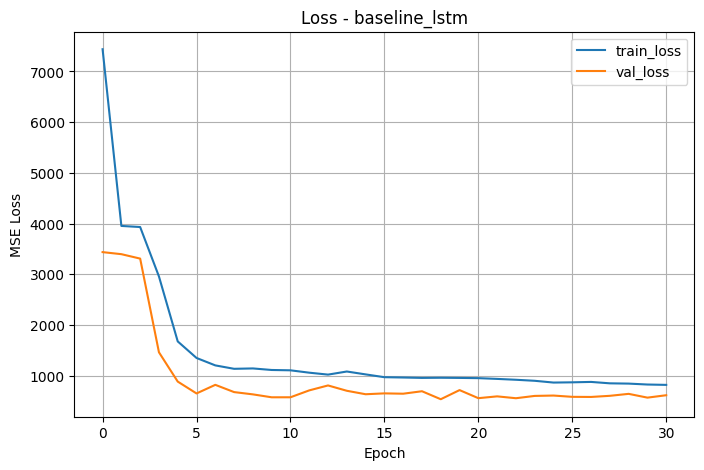

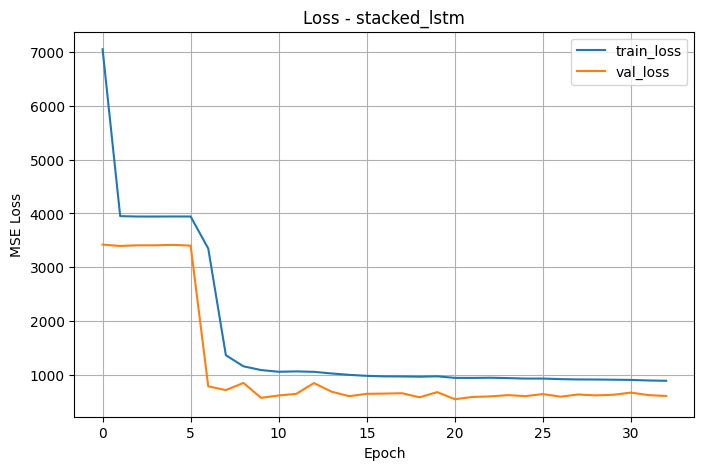

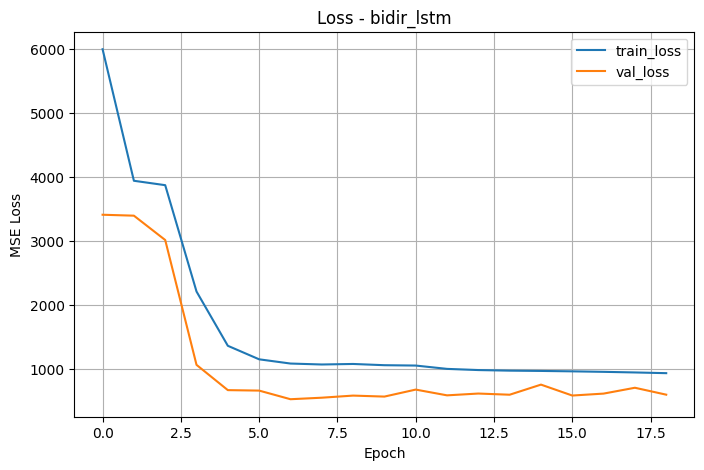

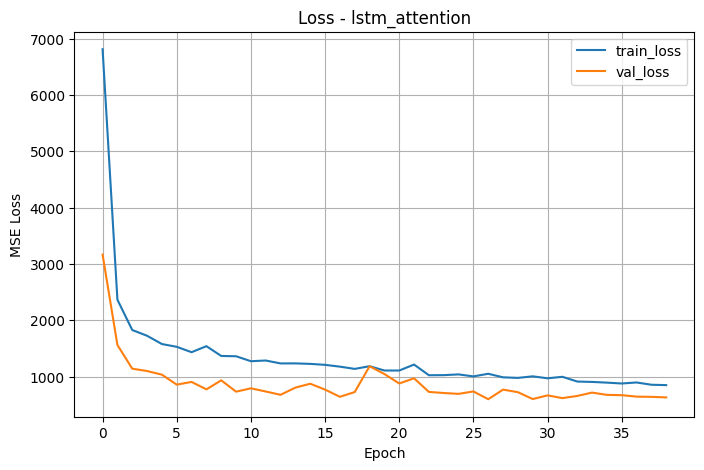

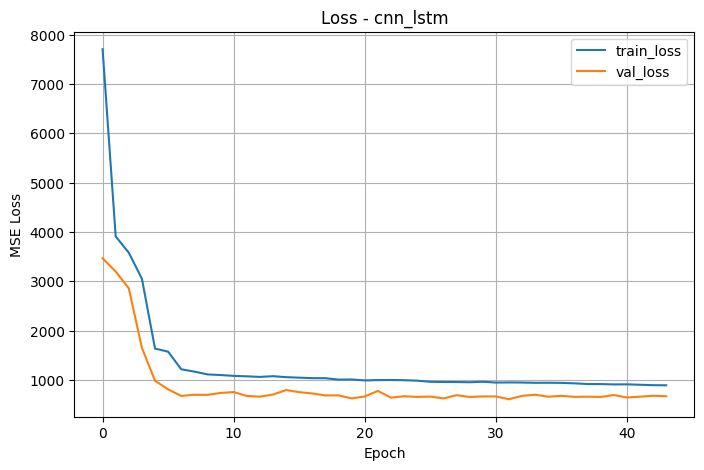

In [ ]:
def plot_loss(history, title=None, savepath=None):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
    plt.title(title or 'Loss')
    plt.legend(); plt.grid(True)
    if savepath: plt.savefig(savepath)
    plt.show()

for name, h in HISTORIES.items():
    plot_loss(h, title=f'Loss - {name}', savepath=os.path.join(OUT_DIR, f'{name}_loss.png'))

**10 . Provide Final Report of this Experiement**

In [ ]:
results = {}
for name, model in models_to_run.items():
    ckpt_path = os.path.join(OUT_DIR, f'{name}_best.h5')
    if os.path.exists(ckpt_path):
        model.load_weights(ckpt_path)
    preds = model.predict(X_val, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    results[name] = rmse

report = {
    'date': datetime.now().isoformat(),
    'dataset': 'CMAPSS FD001',
    'seq_len': SEQ_LEN,
    'n_features': N_FEATURES,
    'models_tried': list(models_to_run.keys()),
    'validation_rmse': results
}

# Save JSON and markdown
with open(os.path.join(OUT_DIR, 'report.json'), 'w') as f:
    json.dump(report, f, indent=2)

md_lines = [f"# RUL LSTM Experiment Report\n",
            f"**Date:** {report['date']}\n",
            f"**Dataset:** {report['dataset']}\n",
            f"**Seq length:** {SEQ_LEN}, **Features:** {N_FEATURES}\n",
            "## Models and Validation RMSE\n"]
for k,v in results.items():
    md_lines.append(f"- {k}: {v:.4f}\n")
with open(os.path.join(OUT_DIR, 'report.md'), 'w') as f:
    f.writelines(md_lines)

print('Experiment report saved in outputs/')

Experiment report saved in outputs/
